In [ ]:
# import packages
import math, re, os, random, cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.12.0


In [ ]:
# testing TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
# setting hyperparameters

# AUTOTUNE: a value used for configuring the tf.data pipeline, which
# automatically adjusts the number of parallel processing units based on
# available system resources.
AUTOTUNE = tf.data.experimental.AUTOTUNE

# BATCH_SIZE: the number of training examples to process in each batch.
# The batch size is multiplied by the number of replicas in sync, which
# determines the number of TPU cores used for training.
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# IMAGE_SIZE: the desired size of the input images for training the model.
# In this case, the images will be resized to 224x224 pixels.
IMAGE_SIZE = [224, 224]

# CLASSES: a list of class labels for the classification task.
CLASSES = ['0', '1', '2', '3', '4']

# EPOCHS: the number of times the entire training dataset will be used to train
# the model. This is set to 100 in this case, but it may be changed for
# different experiments.
EPOCHS = 100 # Dear God, this has to be different if we're testing it
EPOCHS5 = 5 # Alternative with only 5
EPOCHS3 = 20 # Alternative with only 3

# LR: the learning rate used by the optimizer during training. A learning rate
# of 0.0001 is set for this experiment, but it can be tuned for optimal results
# A desirable learning rate is one that's low enough so that the network
# converges to something useful but high enough so that it can be trained in a
# reasonable amount of time
LR = 0.0001

In [ ]:
# Why we have set the image size as 224x224

# The ResNet-50 model takes an input image of size 224x224 pixels, with 3 color
# channels (RGB). This input size is defined by the input layer of the model,
# which expects a tensor of shape (batch_size, 224, 224, 3).

# ResNet-50 is a convolutional neural network architecture that was originally
# proposed for the ImageNet Large Scale Visual Recognition Challenge in 2015.
# The model consists of 50 layers and is known for its skip connections, which
# help to address the vanishing gradient problem that can occur in deep neural
# networks.

# While the input image size for ResNet-50 is fixed at 224x224, the output of
# the model can vary depending on the specific task being performed.
# For example, in a classification task with 1000 classes, the output of the
# model would be a probability distribution over the 1000 classes, represented
# as a tensor of shape (batch_size, 1000).

In [ ]:
# mount drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Change this to what your path is in Google Drive
path = "/content/drive/MyDrive/00_MIS_548/cassava-leaf-disease-classification"

In [ ]:
# split data into training and validation data
training_filenames, valid_filenames = train_test_split(
    tf.io.gfile.glob(path + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.2, random_state=5
)

In [ ]:
# define functions to process TFRecords data using below website
# https://www.kaggle.com/jsmithperera/cassava-inference

# tf.image.decode_jpeg: decodes a JPEG-encoded image to a 3D tensor with dtype
# uint8.
# tf.cast: converts the image tensor to float32 dtype.
# Division by 255: Scales the pixel values from the range [0, 255] to [0, 1].
# This is a common preprocessing step for image data to ensure that all pixel
# values are within the same range, which can help the model learn more
# effectively.
# tf.image.resize: resizes the image tensor to the desired IMAGE_SIZE, which is
# set to [224, 224] in this case.
# tf.reshape: reshapes the tensor to have 3 color channels. The shape of the
# tensor will be [224, 224, 3].
# This function is typically applied to a batch of input images using the
# tf.data pipeline during training. It can help to ensure that all input images
# are consistently preprocessed in the same way, which can improve the
# performance of the model.

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

def data_augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

In [ ]:
# functions to get training, validation, and testing data set
# https://www.kaggle.com/jsmithperera/cassava-inference

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_training_dataset():
    dataset = load_dataset(training_filenames, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(valid_filenames, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(training_filenames)
NUM_VALIDATION_IMAGES = count_data_items(valid_filenames)

print('Dataset: {} training images, {} validation images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 16045 training images, 5352 validation images


In [ ]:
# Trying to uninstall and reinstall packages to see if that gives me my missing dependencies
# AVOID running this for now if the big import block below works

# !pip3 uninstall tensorflow
# !pip3 install tensorflow

In [ ]:
# Trying specifically the dependencies
# AVOID running this for now if the big import block works

# !pip uninstall keras
# !pip install keras

In [ ]:
# import packages for model construction
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image

# First line below is the original code
# from keras.applications.resnet50 import preprocess_input, decode_predictions # Fails here: no keras.applications.resnet50

# These are my (failed) attempts to fix the line above
# https://stackoverflow.com/questions/54682539/i-am-not-able-to-import-resnet-from-keras-applications-module
# from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import preprocess_input
# import keras.applications.resnet50.preprocess_input

# The link below and the line below worked for me
# https://github.com/gabrieldemarmiesse/heatmaps/issues/2
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

from tensorflow.keras.models import load_model
from keras.callbacks import LearningRateScheduler
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD

# First line below is the original code
# from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

# The links below and the lines below worked for me
# https://stackoverflow.com/questions/72334642/importerror-cannot-import-name-img-to-array-from-keras-preprocessing-image
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from keras.utils.image_utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from sklearn.model_selection import train_test_split

In [ ]:
# more data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip(
      mode='horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(
      factor=(-0.125,0.125)),
])

In [ ]:
# early stopping condition
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                            restore_best_weights=True)

In [ ]:
# This function builds a model using transfer learning with ResNet50 as the base
# model and adds additional layers on top of it for classification. It starts by
# defining the input shape and creating an input layer using tf.keras.Input().
# It then applies data augmentation to the input layer using the
# data_augmentation() function defined earlier.

# The base model is loaded using ResNet50() from the Keras application library
# with pre-trained weights on the ImageNet dataset. The include_top parameter is
# set to False, meaning that the final fully connected layer of the model
# (which is specific to the ImageNet classification task) will not be included.

# The augmented input layer is then passed through the base model to obtain the
# output of the last convolutional layer. This output is then passed through a
# GlobalAveragePooling2D layer to reduce its spatial dimensions. Three fully
# connected layers with 512, 128, and 32 units respectively, are added on top of
# the pooling layer, each followed by a BatchNormalization layer and a ReLU
# activation function.

# The final fully connected layer with a softmax activation function is added to
# produce the classification output, with the number of units equal to the
# number of classes in the dataset.

# The Model() function is used to create the final model, taking the input layer
# and output layer as arguments. The function returns the complete model.


In [ ]:
# function to build model
def build_model():

  inputshape = (224, 224, 3) # input size
  inputs = tf.keras.Input(shape=inputshape)

  x = data_augmentation(inputs) # apply data augmentation

  base_model = ResNet50(weights = 'imagenet', include_top = False,
                        input_shape=inputshape) # load base model

  # add layers to base model
  x = base_model(x)

  # reduce spatial dimensions
  model = GlobalAveragePooling2D()(x)

  # Three fully connected layers with 512, 128, and 32 units respectively, are
  # added on top of the pooling layer, each followed by a BatchNormalization
  # layer and a ReLU activation function.
  model = Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001))(model)
  model = BatchNormalization()(model)
  model = Dense(128,activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001))(model)
  model = BatchNormalization()(model)
  model = Dense(32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001))(model)
  model = BatchNormalization()(model)

  # The final fully connected layer with a softmax activation function is added
  # to produce the classification output, with the number of units equal to the
  # number of classes in the dataset.
  predictions = Dense(len(CLASSES), activation='softmax')(model)

  # The Model() function is used to create the final model, taking the input
  # layer and output layer as arguments. The function returns the complete model.
  model = Model(inputs = inputs, outputs = predictions)
  return model

model = build_model()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                           

In [ ]:
# compile model
model.compile(optimizer=Adam(learning_rate=LR),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Compiling a neural network model using the Adam optimizer with a
# specified learning rate (LR), sparse categorical cross-entropy as the loss
# function, and accuracy as the evaluation metric.

# The Adam optimizer is an algorithm for SGD (stochastic gradient descent) that
# is commonly used in deep learning. The learning rate (LR) determines the step
# size of the optimizer, and it is typically set to a small value to ensure the
# optimization process is stable.

In [ ]:
# set hyperparameters
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [ ]:
# get training and validation data
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [ ]:
# train model
history = model.fit(train_dataset,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS3, # Number of epochs. I'm pretty sure you can literally just substitute a value here
                    validation_data=valid_dataset,
                    callbacks=[callback]
                    )

Epoch 1/20
1002/1002 [==============================] - 269s 239ms/step - loss: 2.3914 - accuracy: 0.6413 - val_loss: 2.5267 - val_accuracy: 0.6179
Epoch 2/20
1002/1002 [==============================] - 213s 213ms/step - loss: 2.0503 - accuracy: 0.7367 - val_loss: 2.1891 - val_accuracy: 0.6962
Epoch 3/20
1002/1002 [==============================] - 217s 216ms/step - loss: 1.8634 - accuracy: 0.7563 - val_loss: 1.8350 - val_accuracy: 0.7608
Epoch 4/20
1002/1002 [==============================] - 217s 217ms/step - loss: 1.6985 - accuracy: 0.7683 - val_loss: 1.7737 - val_accuracy: 0.7298
Epoch 5/20
1002/1002 [==============================] - 213s 212ms/step - loss: 1.5090 - accuracy: 0.7751 - val_loss: 1.4135 - val_accuracy: 0.8044
Epoch 6/20
1002/1002 [==============================] - 213s 213ms/step - loss: 1.3442 - accuracy: 0.7806 - val_loss: 1.1921 - val_accuracy: 0.8096
Epoch 7/20
1002/1002 [==============================] - 213s 212ms/step - loss: 1.1803 - accuracy: 0.7901 - val_

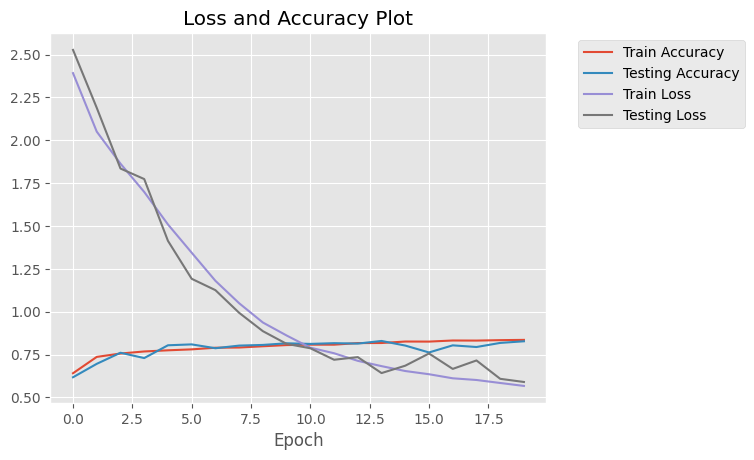

In [ ]:
# plot results
import matplotlib.pyplot as plt

# N = 45
# N = 5
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="Testing Accuracy")
plt.plot(np.arange(0, N), history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="Testing Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("midterm_plot.png")

In [ ]:
# save model
# https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l07c01_saving_and_loading_models.ipynb#scrollTo=OGNpmn43C0O6

import time
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1682800848.h5
./1682800848


In [ ]:
# download model to computer

!zip -r model.zip {export_path_sm}

try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

  adding: 1682637674/ (stored 0%)
  adding: 1682637674/variables/ (stored 0%)
  adding: 1682637674/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1682637674/variables/variables.index (deflated 80%)
  adding: 1682637674/saved_model.pb (deflated 91%)
  adding: 1682637674/assets/ (stored 0%)
  adding: 1682637674/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>